# Imports

In [518]:
import numpy as np
from adaptive_latents.transforms.ica import mmICA
from adaptive_latents.transforms.proSVD import  proSVD
import adaptive_latents as al
import matplotlib.pyplot as plt
import timeit
from scipy.stats import kurtosis, ortho_group
from picard import permute

from sklearn.decomposition import FastICA, PCA

rng = np.random.default_rng()

# Define a Dataset

In [519]:
A,  beh, t, beh_time = map(lambda x: x[:-10], al.construct_indy_data(al.input_sources.datasets.individual_identifiers['indy'][-1], .03))

# A, beh, t, beh_time = al.construct_buzaki_data(individual_identifier=al.input_sources.datasets.individual_identifiers['buzaki'][-1], bin_width=.03)

print(f"dataset is {(t[-1] - t[0])/60:.1f} minutes long")

A_true = None

dataset is 13.6 minutes long


In [520]:
# n_timepoints, n_dimensions = 27_256, 315
n_timepoints, n_dimensions = 10_000, 10

# A_true = rng.laplace(size=(n_timepoints, n_dimensions))
# A_true = rng.standard_cauchy(size=(n_timepoints, n_dimensions))
A_true = rng.poisson(1, size=(n_timepoints, n_dimensions))

W = rng.normal(size=[A_true.shape[1]]*2)
# W = ortho_group.rvs(A_true.shape[1])

A = A_true @ W



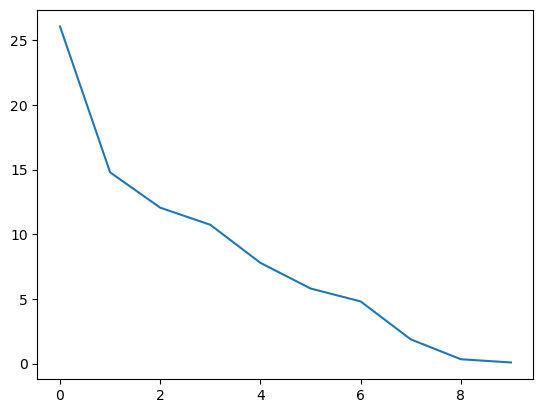

In [521]:
pca = PCA().fit(A)
plt.plot(pca.explained_variance_)

# Run mmICA

In [522]:
block_size = 10
assert block_size <= A.shape[1]

pro = proSVD(k=block_size, centering=True)
ica = mmICA(p=block_size, density='huber', track_extra_info=True, maxiter_cg=20, tol=1e-15)

start_index = block_size + (A.shape[0] % block_size)
pro.initialize(A[:start_index, :].T)

Ws = []
Qs = []
ica_times = []
pro_times = []

for block in A[start_index:,:].reshape(-1, block_size, A.shape[1]):
    start = timeit.default_timer()
    block = pro.update_and_project(block.T)
    pro_times.append(timeit.default_timer() - start)


    start = timeit.default_timer()
    ica.observe_new_batch(block)
    ica_times.append(timeit.default_timer() - start)

    Ws.append(ica.W.copy())
    Qs.append(pro.Q.copy())

Ws = np.array(Ws)
Qs = np.array(Qs)
ica_times = np.array(ica_times)
pro_times = np.array(pro_times)

In [523]:
assert np.all(~np.isnan(Ws))

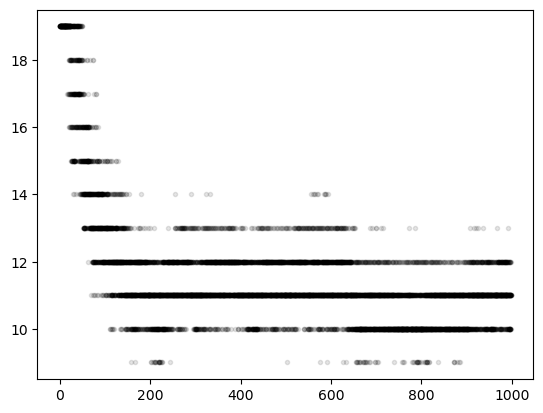

In [524]:
plt.plot(np.array(ica.hit_iter_history), '.', alpha=.1, color='k');

/tmp/ipykernel_179296/2119868526.py:4: RuntimeWarning: All-NaN slice encountered
  m = np.nanmax(ica.hit_norm_history[:,:,:], axis=1)


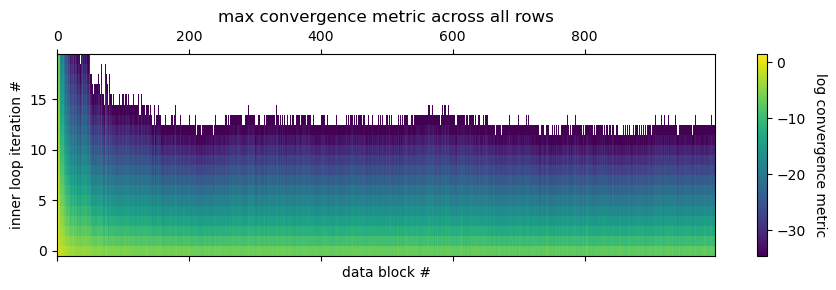

In [525]:
fig, ax = plt.subplots(layout='tight', figsize=(9,3))
ica.hit_norm_history = np.array(ica.hit_norm_history)
# m = ica.hit_norm_history[:200,7,:]
m = np.nanmax(ica.hit_norm_history[:,:,:], axis=1)
c = ax.matshow(np.log(np.squeeze(m)).T, vmin=np.log(ica.tol), origin='lower', aspect='auto')
ax.set_xlabel("data block #")
ax.set_ylabel("inner loop iteration #")
ax.set_title("max convergence metric across all rows")
cbar = fig.colorbar(c)

cbar.ax.get_yaxis().labelpad=15
cbar.set_label("log convergence metric", rotation=270)



# Asess performance

## Time to run

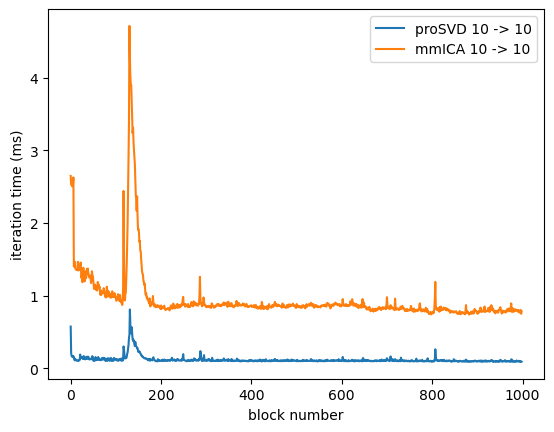

In [526]:
plt.plot(pro_times * 1_000, label=f"proSVD {pro.Q.shape[0]} -> {pro.Q.shape[1]}")
plt.plot(ica_times * 1_000, label=f"mmICA {ica.W.shape[0]} -> {ica.W.shape[0]}")

plt.xlabel("block number")
plt.ylabel("iteration time (ms)")
plt.legend()

## Kurtosis

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


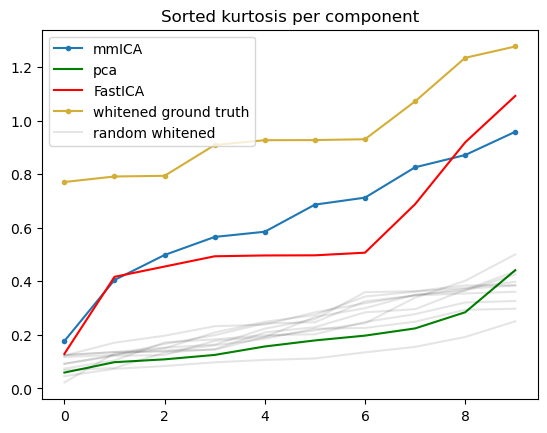

In [527]:
fig, ax = plt.subplots()


datasets = {}

dim_reduced_data = pro.project(A.T)
datasets['input'] = dim_reduced_data
datasets['mmICA'] = ica.W @ dim_reduced_data

sk_ica = FastICA(max_iter=800, whiten='unit-variance').fit(dim_reduced_data.T)
datasets['FastICA'] = sk_ica.transform(dim_reduced_data.T).T

sk_pca = PCA().fit(dim_reduced_data.T)
datasets['pca'] = sk_pca.transform(dim_reduced_data.T).T


def whiten(x):
    whitened_data = (x - x.mean(axis=1)[:,None])
    u, s, v_h = np.linalg.svd(whitened_data, full_matrices=False)
    s = s/np.sqrt(whitened_data.shape[1] - 1)
    return u @ np.diag(1/s) @ u.T @ whitened_data

if A_true is not None:
    datasets['ground truth'] = A_true[:,:block_size].T
    datasets['whitened ground truth'] = whiten(A_true[:,:block_size].T)



whitened_data = whiten(dim_reduced_data)

datasets['random whitened'] = lambda: ortho_group.rvs(ica.W.shape[0]) @ whitened_data
datasets['random'] = lambda: rng.normal(size=[ica.W.shape[0]]*2) @ whitened_data


single_line_styles = {
    'mmICA': dict(color='C0', linestyle='-', marker='.'),
    # 'input': dict(color='orange'),
    # 'ground truth': dict(color='#D4AF37'),
    'whitened ground truth': dict(color='#D4AF37', marker='.'),
    'FastICA': dict(color='red'),
    'pca': dict(color='green'),
}

evaluation_metrics = {
    'kurtosis': lambda x: kurtosis(x.T),
    '4th power': lambda x: ((x.T ** 4 - 3)/4).mean(axis=0),
    'log cosh': lambda x: (np.log(np.cosh(x.T)) - .375).mean(axis=0),
    'exp': lambda x: -np.exp((-.5 * x.T**2) - .707).sum(axis=0),
    'var': lambda x: np.var(x.T, axis=0),
}

metric_name = 'kurtosis'
evaluation_metric = evaluation_metrics[metric_name]

for key in set(single_line_styles).intersection(set(datasets)):
    dataset = datasets[key]
    idx = np.argsort(evaluation_metric(dataset))
    sorted_dataset = dataset[idx, :]
    datasets[key] = sorted_dataset
    ax.plot(np.arange(block_size), evaluation_metric(sorted_dataset), label=key, **single_line_styles[key])

multi_line_styles = {
    'random whitened': dict(alpha=.1, color='k'),
    # 'random': dict(alpha=.1, linestyle='--', color='k'),
}
for key in set(multi_line_styles).intersection(set(datasets)):
    for i in range(10):
        dataset = datasets[key]()
        idx = np.argsort(evaluation_metric(dataset))
        sorted_dataset = dataset[idx, :]
        label = key if i == 0 else None
        ax.plot(np.arange(block_size), evaluation_metric(sorted_dataset), label=label, **multi_line_styles[key])

ax.set_title(f"Sorted {metric_name} per component")
ax.legend();



## Compare offline and online

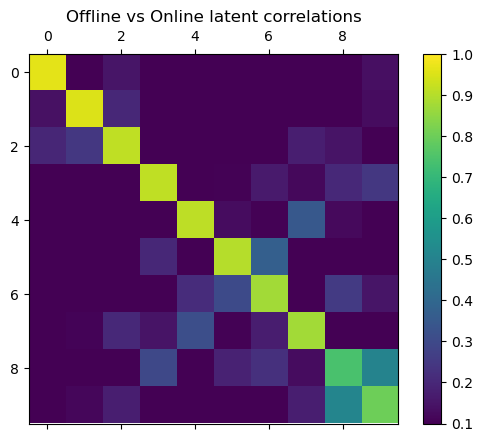

In [528]:
fig, ax = plt.subplots()
k1, k2 = 'mmICA', 'FastICA'
cov = np.abs(np.corrcoef(datasets[k1], datasets[k2])[:-datasets[k2].shape[0],datasets[k1].shape[0]:])
cov = permute(cov, scale=False)
c = ax.matshow(cov, vmin=0.1, vmax=1)
fig.colorbar(c)
ax.set_title("Offline vs Online latent correlations");

## Correlation with true latents

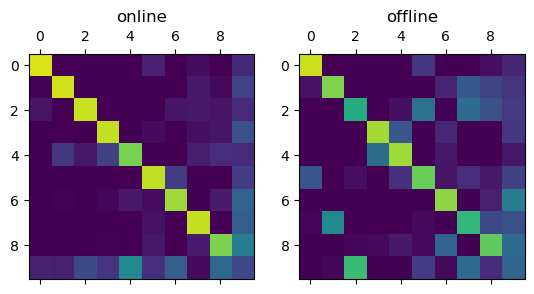

In [529]:
if A_true is not None:
    fig, ax = plt.subplots(ncols=2)

    cov = np.corrcoef(A_true.T, datasets['mmICA'])[:-datasets['mmICA'].shape[0],A_true.shape[1]:]
    if A_true.T.shape == datasets['mmICA'].shape:
        cov = permute(cov, scale=False)
    ax[0].matshow(np.abs(cov), vmin=.1, vmax=1)
    ax[0].set_title("online")


    cov = np.corrcoef(A_true.T, datasets['FastICA'])[:-datasets['FastICA'].shape[0],A_true.shape[1]:]
    if A_true.T.shape == datasets['FastICA'].shape:
        cov = permute(cov, scale=False)
    ax[1].matshow(np.abs(cov), vmin=.1, vmax=1)
    ax[1].set_title("offline")



## Convergence

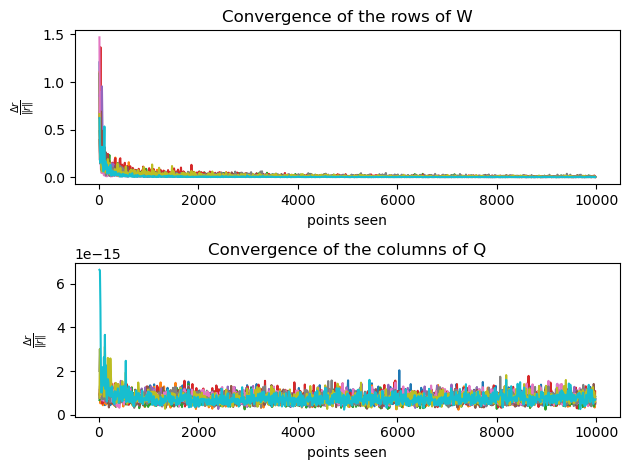

In [530]:
fig, ax = plt.subplots(nrows=2, layout='tight')

changes = np.linalg.norm(np.diff(Ws, axis=0), axis=2) / np.linalg.norm(Ws, axis=2)[:-1]
ax[0].plot((np.arange(changes.shape[0]) + 1)*block_size,changes)
ax[0].set_title("Convergence of the rows of W")
ax[0].set_xlabel("points seen")
ax[0].set_ylabel(r"$\frac{\Delta r}{\Vert r \Vert}$")
# ax[0].set_ylim([0,.1])

changes = np.linalg.norm(np.diff(Qs, axis=0), axis=1)/ np.linalg.norm(Qs, axis=1)[:-1]
# changes = (np.diff(Qs, axis=0)**2).mean(axis=(1,2))
ax[1].plot((np.arange(changes.shape[0]) + 1)*block_size,changes)
ax[1].set_title("Convergence of the columns of Q")
ax[1].set_xlabel("points seen")
ax[1].set_ylabel(r"$\frac{\Delta r}{\Vert r \Vert}$");
# ax[1].set_ylim([0,.1]);



## The distribution metric

<BarContainer object of 10 artists>

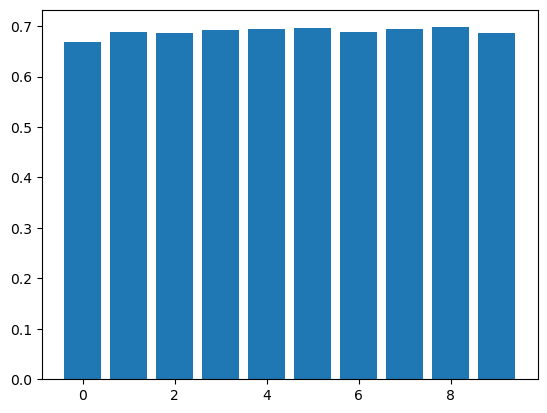

In [531]:
demixed_data = ica.W @ pro.project(A.T)
statistics = ica.density.logp(demixed_data).mean(axis=1)
plt.bar(x=np.arange(len(statistics)), height=statistics)

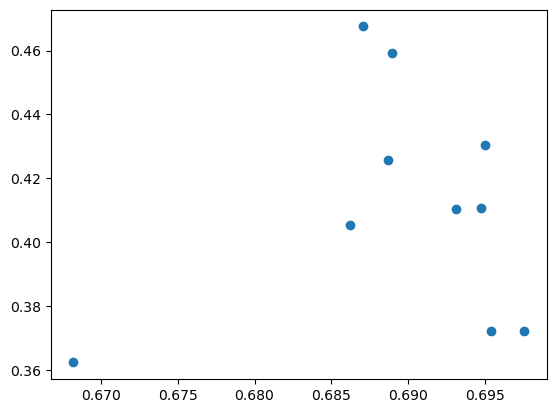

In [532]:
plt.scatter(statistics, ica.cumulants)